This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict 
import math
import json
import re
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,classification_report,recall_score, f1_score,average_precision_score,precision_score
import pickle
import joblib


sns.set_theme(style="whitegrid")
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Exploration

In [3]:
#checking for outliers and Nans
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [4]:
# number of customers
profile.shape[0]

17000

In [5]:
#checking basic statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


118    2175
101       5
Name: age, dtype: int64

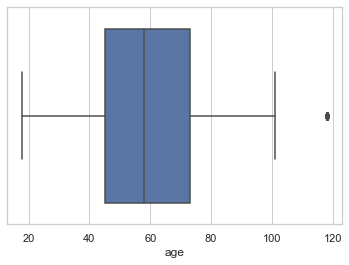

In [6]:
#checking for outliers and Nans
sns.boxplot(profile.age);
profile.age[profile.age > 100].value_counts()

In [7]:
#checking for outliers and Nans
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

Cleaning

In [8]:

def clean_portfolio(df):
    
    portfolio = df.copy()
    
    #extract channels
    channels = set()

    for label, value in portfolio["channels"].iteritems():
        for i in value:
            channels.add(i)

    #create dummy variables for channels
    for channel in channels:
        portfolio[channel] = portfolio["channels"].apply(lambda x: 1 if channel in x else 0)

    portfolio_cleaned = portfolio.drop("channels", axis =1).rename(columns={"id":"offer_id", 
                                                                            "offer_type":"offer_category"})
    
    #create new offer types to dinstinguish  
    portfolio_cleaned["offer_type"] = portfolio["offer_type"].str.cat(portfolio["reward"].astype(str), 
                                    sep='_').str.cat(portfolio["difficulty"].astype(str), 
                                                    sep ='_').str.cat(portfolio["duration"].astype(str),sep ='_')

    
    return  portfolio_cleaned